<h1><center>Organizando Projetos de Machine Learning</center></h1>


Finalmente já podemos construir nosso primeiro modelo de machine learning.

Antes de começarmos temos que nos atentar a algumas coisas. Lembre-se de que iremos trabalhar com a IDE/ editor de texto no lugar de jupyter notebook. Caso você queira utilizar jupyter notebook, não tem problema algum. Irei utilizar o jupyter notebook somente para ilustrar os códigos e plotar os gráficos quando necessário.

Iremos construir um framework de classificação de modo que os problemas se tornarão plug n'play. **Você poderá trainar um modelo sem a necessidade de muitas mudanças no código e, quando melhorar seu modelo, você saberá monitorá-lo utilizando o git.**

Vamos olhar para a estrutura dos arquivos primeiramente. Para cada projeto que for construir, crie um folder novo. Por exemplo, estou chamando o projeto de "project".

O interior do projeto deve parecer algo algo como a imagem abaixo:

<br>

<center><img src="project-tree.png"/></center>

<br>

Muitas pessoas ficam em dúvida de como estruturar seus projetos de Machine Learning. A estrutura que mostro aqui apresenta um framework de classificação de modo que os problemas se tornarão plug n'play. **Você poderá trainar um modelo sem a necessidade de muitas mudanças no código e, quando melhorar seu modelo, você saberá monitorá-lo utilizando o git.** Vale a pena ter domínio não só dos códigos mas também do gerenciamento, engenharia de todo o projeto para que a gente consiga dar uma escalabilidade cada vez melhor e de maneira mais efetiva.

Vamos entender cada um dos folders:

* **input/** : Esse folder contém todos os arquivos de input e os dados do projeto de machine learning. Se você estiver trabalhando com projeto de NLP, você pode deixar suas word embeddings aqui. Se estiver trabalhando com projeto de imagens, todas as imagens podem estar dentro de subfolders dentro do folder input.

* **src/** : Aqui nós deixaremos todos os scripts python associados ao projeto. Se eu me referir a script python , exemplo qualquer arquivo *.py estarei me referindo a arquivos nesse folder.

* **models/** : Esse folder contém os modelos treinados.

* **notebooks/** : Todos os jupyter notebooks estarão nesse folder.

* **README.md**: Esse será o arquivo markdownonde nós podemos descrever seu projeto e escrever instruções de como treinar o modelo ou como coloca-lo em um ambiente de produção.

* **LICENSE:**: Esse é um text file que consiste da licença do projeto, como por exemplo o MIT, Apache, etc.

Vamos supor que você queira desenvolver um modelo de classificação com dataset MNIST ( Um dataset que é utilizado em quase todo livro de machine learning ). Se você se lembrar, usamos esse mesmo dataset no capítulo de cross-validation.Então, não vou explicar sobre esse dataset. Existem muitos formatos do MNIST dataset disponíveis online, mas iremos utilizar o formato CSV.

Nesse formato do dataset, cada row (linha) do CSV file consiste dos labels das imagens e 784 valores de pixels que variam de 0 a 255. O dataset contém 60000 imagens nesse formato.

Podemos usar o pandas para ler os dados facilmente.

**O plot abaixo deixa claro que a distribuição dos labels é aproximadamente uniforme. Podemos então usar *accuracy/F1* como métricas. Esse é o primeiro passo quanto estiver desenvolvendo qualquer projeto de machine learning: decida a métrica!**

In [6]:
import pandas as pd
import os
input_file_path = os.path.join("project","input","mnist_train.csv")
df = pd.read_csv(input_file_path)
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

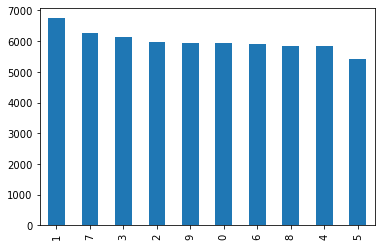

In [11]:
df.label.value_counts().plot.bar()

<br>

Agora podemos codar um pouco. Precisamos criar um folder (pasta) *src/* e alguns scripts python.

Favor notar que o csv de treino está dentro do folder *input* com o nome *mnist_train.csv*.]

O primeiro script que deve ser criado é o **create_folds.py**. Esse irá criar um novo arquivo no folder *input/* chamado mnist_train_folds.csv como o mesmo nome do arquivo de treino *mnist_train.csv*. A única diferença é que esse arquivo CSV estará embaralhado e com uma nova coluna chamada kfold.

Uma fez que decidimoso qual métrica de avaliação utilizar e tivermos criado os folds, estaremos pronto para criar nosso primeiro modelo. Isso é feito no script **train.py**.

Abaixo temos parte do código que criar os folds ( *project/scr/create_folds.py* ). Lembrando que aqui no notebook estamos apresentando somente a parte do código que executa o processo. O código todo estruturado encontra-se em *./project/csr/create_folds.py*

In [23]:
#src/create_folds

from sklearn import model_selection
import pandas as pd

train_path = "./project/input/mnist_train.csv"
df = pd.read_csv(train_path)

df["kfold"] = -1

df = df.sample(frac=1).reset_index(drop=True)
y = df.label.values

kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

path = './project/input/mnist_train_folds.csv'

df.to_csv(path, index=False)

<br>

Agora que os folds foram criados, podemos então criar o train.py.

In [26]:
#scr/train.py
import joblib
import pandas as pd
from sklearn import metrics
from sklearn import tree

def run(fold):
    # ler os dados de treino com folds
    df = pd.read_csv("../input/mnist_train_folds.csv")
    
    # Dados de treino são os que apresentam folds diferentes dos folds em questão
    # note que deletamos os index
    df_train =df[df.fold != fold].reset_index(drop = True)
    